## Track fish in widefield fluorescence images
This notebook assumes multiple (16+) cores are available for parallel computation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from skimage.io import imread
import fishtrack.alignment as align
import fishtrack.filters as fish_filters
from pathlib import Path
import json
import flika as flk
import dask.bag as bg
from dask.bag import from_sequence as tobag
from fishtrack.measurements import remotest_point
flk.start_flika()
from flika.window import Window as flw
from functools import partial  
from fish.image.zds import to_dask
from dask.delayed import delayed

%matplotlib inline

Starting flika
Starting flika inside IPython


In [8]:
from fish.util.distributed import get_cluster
from dask.distributed import Client
cluster = get_cluster()
#cluster.adapt(startup_cost='2s', interval='1s')
client = Client(cluster)
client

Client Scheduler: tcp://10.36.110.40:38438 Dashboard: http://10.36.110.40:33380/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [3]:
def save_params(params, fname):
    import json
    with open(fname,'w') as f:
        json.dump(params, f)
        
def mem_use():
    import os
    import psutil
    pid = os.getpid()
    py = psutil.Process(pid)
    memory_use = py.memory_info()[0]/2.**30  # memory use in GB...I think
    return memory_use

def pool_wrapper(function, data, num_cores, mode='map'):
    from multiprocessing import Pool
    with Pool(num_cores) as p:
        try:
            if mode == 'map':
                result = p.map(function, data)
            elif mode == 'starmap':
                result = p.starmap(function, data)
        except Exception as inst:
            print('There was a problem!')
            print(inst)
            return None
    return result

def sparse_center_of_mass(image):
    from scipy.sparse import issparse
    from scipy.ndimage.measurements import center_of_mass
    from numpy import array, nan
    
    image_ = image.copy()
    result = (nan, nan)
    
    if issparse(image_):
        image_ = array(image_.todense())
    
    if image_.any():
        result = center_of_mass(image_)
    
    return result


def get_mask_stats(masks):
    from scipy.ndimage.measurements import center_of_mass
    from numpy import array
    from scipy.sparse import issparse    
    
    mask_stats = {}
    masks_ = masks.copy()
    if issparse(masks_[0]):
        mask_stats['area'] = array([f.sum() for f in masks_])
        mask_stats['com'] = array([center_of_mass(array(f.todense())) for f in masks_])
    else:
        mask_stats['area'] = array([f.sum() for f in masks_])
        mask_stats['com'] = array([center_of_mass(f) for f in masks_])
    return mask_stats

In [4]:
base_paths = ['/nrs/ahrens/ahrenslab/davis/data/epi/20170621/6dpf_cy221xcy221_f1_spon_1/',
             '/nrs/ahrens/davis/data/epi/20170621/6dpf_cy221xcy221_f1_spon_2/', 
             '/nrs/ahrens/davis/data/epi/20170621/6dpf_cy221xcy221_f2_spon_1/',
             '/nrs/ahrens/davis/data/epi/20170621/6dpf_cy221xcy221_f2_spon_2/',
             '/nrs/ahrens/davis/data/epi/20170621/6dpf_cy221xcy221_f3_spon_1/',
             '/nrs/ahrens/davis/data/epi/20170621/6dpf_cy221xcy221_f4_spon_1/',
             '/nrs/ahrens/davis/data/epi/20170621/6dpf_cy221xcy221_f4_spon_2/',
             '/nrs/ahrens/davis/data/epi/20170621/6dpf_cy221xcy221_f5_spon_1/',
             '/nrs/ahrens/davis/data/epi/20170621/6dpf_cy221xcy221_f5_spon_2/',
             '/nrs/ahrens/davis/data/epi/20170621/6dpf_cy221xcy221_f6_spon_1/',
             '/nrs/ahrens/davis/data/epi/20170909/7dpf_cy221xcy221_f1_1/'] 

In [5]:
im_fnames = [sorted(glob(d + 'Pos0/*.tif')) for d in base_paths]

In [9]:
%%time
cluster.start_workers(30)
to_load = -1
plr_load = slice(0, None)

fnames = im_fnames[to_load][plr_load]
exp_name = str(Path(fnames[0]).parts[-3])
mask_dir = base_paths[to_load] + 'masks/'
mask_fnames = sorted(glob(mask_dir + 't*.npz'))
print('Current experiment: {0}'.format(exp_name))
param_fname = '{0}_params.json'.format(exp_name)

# try to load masks
if len(mask_fnames) > 0:
    from scipy.sparse import load_npz
    # likely cpu bound
    fish_masks = np.array(tobag(mask_fnames).map(load_npz).compute())
    print('Loaded fish masks')

else:
    fish_masks = None
    print('No masks found')

if Path(base_paths[to_load] + param_fname).exists():
    with open(base_paths[to_load] + param_fname, 'r') as f:
        params = json.load(f)
        print('Params loaded')
else:
    params = None
    print('Param file {0} not found'.format(param_fname))

# likely IO bound
ims = to_dask(fnames).compute()
print(ims.shape)
cluster.stop_workers(cluster.workers)

Current experiment: 7dpf_cy221xcy221_f1_1
Loaded fish masks
Params loaded
(60000, 512, 512)
CPU times: user 4min 20s, sys: 3min 47s, total: 8min 7s
Wall time: 7min 1s


## Set up params 

In [10]:
if params is None:
    params = {}
    # args for the fish mask finding
    params['fish_mask'] = {'sigma' : 2, 'disk_size' : 40, 'shrink_factors' : [.1,.1], 'min_sizes' : [100,100]}
    # set bbox to crop around the fish, formatted [x_start, y_start, x_end, y_end]
    params['fish_bbox'] = [-200, -100, 40, 100]
    # estimated size of the brain; used for fine registration
    params['brain_size'] = [80, 100]
    save_params(params, base_paths[to_load] + param_fname)    

## Get fish masks

In [11]:
fish_mask_wrapper = partial(fish_filters.get_fish_mask ,**params['fish_mask'])        

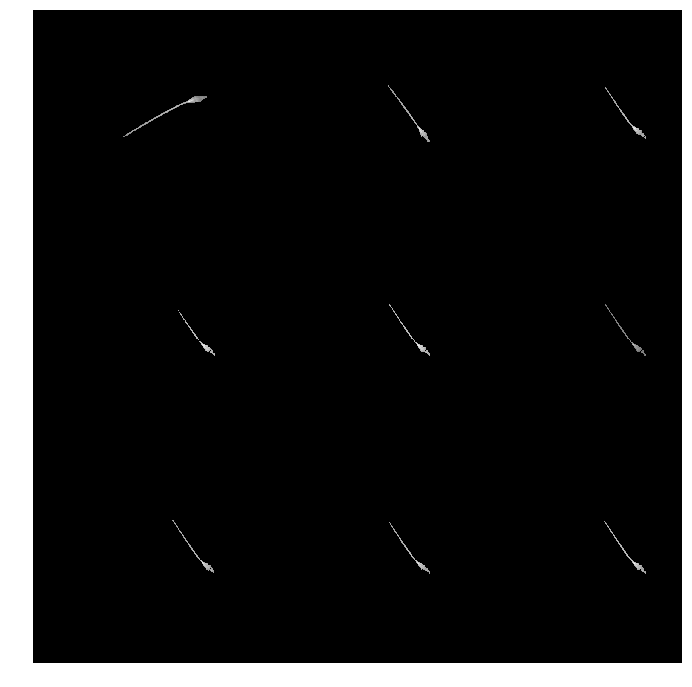

In [12]:
nr = 3
nc = 3
fig, axs= plt.subplots(nrows=nr, ncols=nc, figsize=(nr * 4,nc * 4))

times = np.linspace(0, (len(ims) - 1), nr*nc).astype('int')

for ind, ax_ in enumerate(axs.ravel()):
    im_ = ims[times[ind]]
    msk = np.array(fish_mask_wrapper(im_).todense())
    ax_.imshow(im_*msk, origin='lower', cmap='gray')
    ax_.axis('off')
plt.subplots_adjust(wspace=-.1,hspace=0)

## Generate fish masks if they weren't loaded

In [13]:
%%time
if fish_masks is None:
    fish_masks = np.array(bg.map(fish_mask_wrapper, tobag(ims)).compute())    

CPU times: user 207 µs, sys: 137 µs, total: 344 µs
Wall time: 45.1 µs


## Save masks

In [14]:
%%time
from os import mkdir
from os.path import exists
if not exists(mask_dir):
    mkdir(mask_dir)

from scipy.sparse import save_npz
mask_fnames = [mask_dir + 't{:09d}_mask.npy'.format(ind) for ind in range(len(fish_masks))]
bg.map(save_npz, tobag(mask_fnames), tobag(fish_masks)).compute(scheduler='processes')

CPU times: user 40.6 s, sys: 36.8 s, total: 1min 17s
Wall time: 1min 45s


In [ ]:
masks_full = np.array([f.toarray() for f in fish_masks])
flw(masks_full.astype('uint8'))

/groups/ahrens/home/bennettd/anaconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:1328: RuntimeWarning: invalid value encountered in double_scalars
  for dir in range(input.ndim)]


CPU times: user 1min 56s, sys: 10.4 s, total: 2min 6s
Wall time: 1min 37s


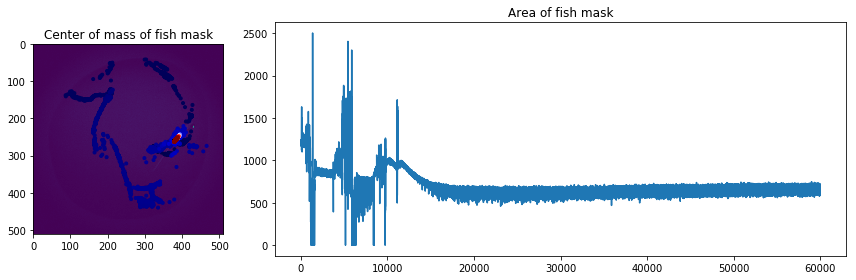

In [15]:
%%time
from matplotlib.cm import seismic
fig, axs = plt.subplots(nrows=1, ncols=2, gridspec_kw={'width_ratios' : (1,3)}, figsize=(12,4))
axs[0].imshow(ims[-1])
fish_mask_stats = get_mask_stats(fish_masks)
com = fish_mask_stats['com'].T[::-1]
colors = seismic(np.linspace(0,1,com.shape[1]))

axs[0].scatter(com[0], com[1], marker='.', color=colors)
axs[0].title.set_text('Center of mass of fish mask')
axs[1].title.set_text('Area of fish mask')
axs[1].plot(fish_mask_stats['area'])
plt.tight_layout()

## Localize the brain and the center of mass of the body

In [16]:
%%time
# here's a place to filter these values to get rid of outliers
cluster.start_workers(30)
fm = tobag(fish_masks)
brain_centers = fm.map(remotest_point).compute()
body_centers = fm.map(sparse_center_of_mass).compute()
cluster.stop_workers(cluster.workers)

CPU times: user 51.5 s, sys: 37 s, total: 1min 28s
Wall time: 2min 9s


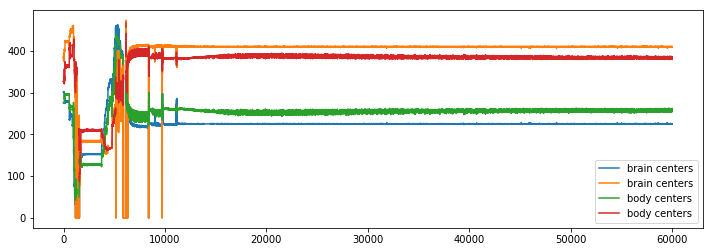

In [17]:
fig, axs = plt.subplots(figsize=(12,4))
axs.plot(brain_centers, label='brain centers')
axs.plot(body_centers, label='body centers')
axs.legend()

## Save body centers and brain centers to disk

In [18]:
np.savez(base_paths[to_load] + exp_name + '_position_data.npz', brain_centers=brain_centers, body_centers=body_centers)

## Get oriented masks and coarse transform parameters

In [19]:
%%time
cluster.start_workers(30)
rotations = bg.map(align.orient_tail, 
                   tobag(fish_masks), 
                   tobag(np.array(brain_centers)), 
                   tobag(np.array(body_centers))).compute()
cluster.stop_workers(cluster.workers)

CPU times: user 33.7 s, sys: 34.1 s, total: 1min 7s
Wall time: 1min 43s


(10000, 12000)

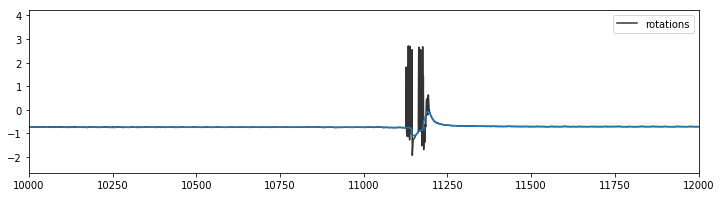

In [25]:
from scipy.ndimage.filters import median_filter
fig, axs = plt.subplots(nrows=1, figsize=(12,3), sharex=True, squeeze=False)
axs[0][0].plot(rotations,'k', alpha=.8, label='rotations')
axs[0][0].plot(median_filter(rotations, size=20))
axs[0][0].legend()
plt.xlim(10000,12000)

## Use transform parameters to generate cropped, masked fish image

In [26]:
%%time
# the crop window is relative to the estimated brain position

bbox = params['fish_bbox']
window_x = np.arange(bbox[0],bbox[2], dtype='int').reshape(-1,1)
window_y = np.arange(bbox[1],bbox[3], dtype='int')
crop_window = (window_y, window_x) 
rotations_ = median_filter(rotations, size=20)
brain_centers_ = median_filter(brain_centers, size=(20,1))
cluster.start_workers(60)
oriented_ims = np.array(bg.map(align.get_cropped_fish, 
                               tobag(ims), 
                               tobag(rotations_), 
                               tobag(brain_centers_),
                               crop_window).compute())
cluster.stop_workers(cluster.workers)
#oriented_ims = np.array(pool_wrapper(align.get_cropped_fish, zip(ims, rotations, brain_centers, crop_window), num_cores, mode='starmap'))

CPU times: user 2min 42s, sys: 2min 31s, total: 5min 13s
Wall time: 6min 6s


In [32]:
%%bash
bkill -q normal 0

JOBID      USER    STAT  QUEUE      FROM_HOST   EXEC_HOST   JOB_NAME   SUBMIT_TIME
43784552   bennett RUN   interactiv c11u25      16*h10u30   /bin/bash  Jul 17 16:50


In [28]:
flw(oriented_ims)

## Do fine alignment on oriented fish images

In [33]:
%%time
cluster.start_workers(120)
t_ref = -1
static = oriented_ims[t_ref]
brain_positions = np.array([np.where(window_y==0)[0][0], np.where(window_x==0)[0][0]])
brain_size =np.array(params['brain_size']) // 2

aligned_ims, txs= zip(*bg.map(align.align_brains, 
                        static, 
                        tobag(oriented_ims, npartitions=1000), 
                        brain_positions, 
                        brain_size).compute())

aligned_ims = np.array(aligned_ims).astype('uint16')
cluster.stop_workers(cluster.workers)

CPU times: user 3min 57s, sys: 4min 48s, total: 8min 46s
Wall time: 12min 12s


In [31]:
flw(aligned_ims)

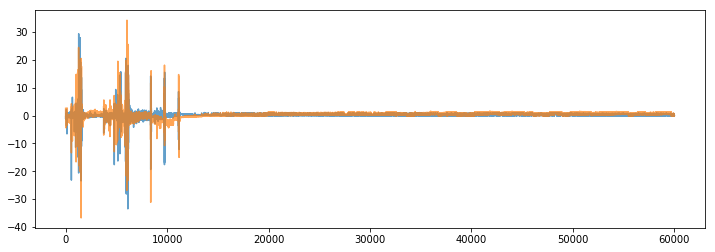

In [34]:
affines = np.array([tx.affine for tx in txs])
fig, axs = plt.subplots(figsize=(12,4))
axs.plot(affines[:,0,-1], alpha=.7)
axs.plot(affines[:,1,-1], alpha=.7)

In [35]:
from skimage.io import imsave 
imsave(base_paths[to_load] + exp_name + '_aligned.tif', aligned_ims)

/groups/ahrens/home/bennettd/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /nrs/ahrens/davis/data/epi/20170909/7dpf_cy221xcy221_f1_1/7dpf_cy221xcy221_f1_1_aligned.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


In [36]:
np.save(base_paths[to_load] + 'regparams.npy', affines)

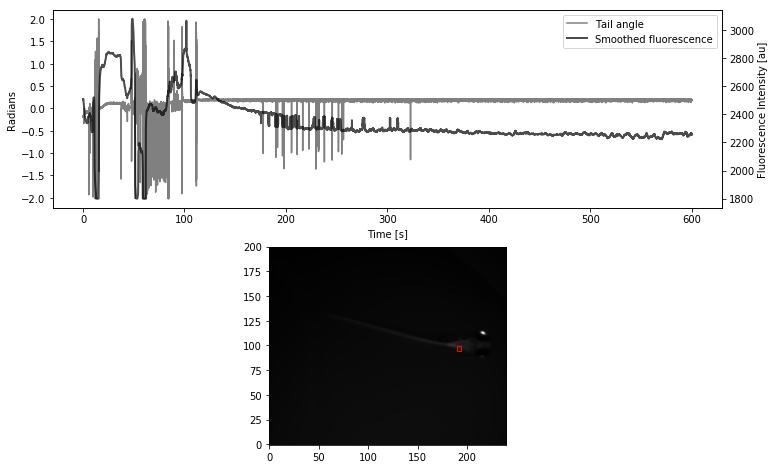

In [49]:
# this roi works for '/groups/ahrens/ahrenslab/davis/data/epi/20170621/6dpf_cy221xcy221_f2_spon_1/Pos0/'
from fishtrack.measurements import tail_angle
from scipy.ndimage.filters import median_filter
roi = (slice(0,None), slice(94,99), slice(190,194))
fs_im = 100
t = np.arange(oriented_ims.shape[0])[roi[0]] / fs_im
fig, axs = plt.subplots(nrows=2, figsize=(12,8))
ax_angle = axs[0]
ax_angle.plot(t, tail_angle(oriented_ims[roi[0]], (100,200), 90)[0], color='grey')
ax_angle.set_ylabel('Radians')
ts = oriented_ims[roi].mean((1,2))
floor_ = 1800
ceil_ = None
ax_fluo = ax_angle.twinx()
#ax_fluo.plot(t, ts.clip(floor_, ceil_), alpha = .4)
ax_fluo.plot(t, median_filter(ts, size=200).clip(floor_, ceil_), linewidth=2, color='k', alpha=.7)
ax_fluo.set_ylabel('Fluorescence Intensity [au]')
axs[0].legend([ax_angle.lines[-1], ax_fluo.lines[-1]], ['Tail angle','Smoothed fluorescence'], )

axs[0].set_xlabel('Time [s]')

from matplotlib.patches import Rectangle
axs[1].imshow(oriented_ims[roi[0]].mean(0), cmap='gray', origin='lower')
rect = Rectangle((roi[2].start, roi[1].start), roi[2].stop - roi[2].start, roi[1].stop - roi[1].start, fill=False, color='r')
axs[1].add_patch(rect)

# Test quality of tail orientation 

## Registration debugging 

In [ ]:
import numpy as np
from skimage.io import imread
from skimage import data_dir
from skimage.transform import rotate
from numpy import rad2deg
from dipy.align.imaffine import AffineRegistration
from dipy.align.transforms import RotationTransform2D 

affreg = AffineRegistration(verbosity=0)
rotation = RotationTransform2D()

static = imread(data_dir + "/phantom.png", as_grey=True)

rot_phi = .3
moving = rotate(static, rad2deg(rot_phi))
mg2w = np.array([[1,0,-moving.shape[0]//2],[0,1,-moving.shape[1]//2],[0,0,1]])
sg2w = mg2w
params0 = None
starting_affine = None
tx = affreg.optimize(static, moving, rotation, params0, static_grid2world=sg2w, moving_grid2world=mg2w, starting_affine=starting_affine)
titles = ['Static', 'Moving', 'Transformed Moving']

samp_g2w = np.eye(3)
samp_g2w[0,-1] = -200
samp_g2w[1,-1] = -200

fig, axs = plt.subplots(ncols = 3)
axs[0].imshow(static, origin='lower')
axs[1].imshow(moving, origin='lower')
axs[2].imshow(tx.transform(moving), origin='lower')
[axs[ind].title.set_text(val) for ind, val in enumerate(titles)]

print('True angle      : {0}'.format(rot_phi))
print('Estimated angle : {0}'.format(np.arccos(tx.affine[0,0])))

In [ ]:
from dipy.align.imaffine import AffineMap
from skimage.transform import AffineTransform
from skimage.transform import warp

In [ ]:
g2ws = np.eye(3)
g2ws[0,2] = -(static.shape[0] / 2)
g2ws[1,2] = -(static.shape[1] / 2)

g2wi = np.eye(3)
g2wi[0,2] = -(static.shape[0] / 2) - 100
g2wi[1,2] = -(static.shape[0] / 2)

affmap_r = AffineMap(np.eye(3))
affmap_r.codomain_shape = static.shape
affmap_r.domain_shape = static.shape

phi = np.pi
affmap_r.affine[:2,:2] = rotmat2d(phi)

dy, dx = 0,-100
affmap_r.affine[0,-1] = dy
affmap_r.affine[1,-1] = dx
rotated = affmap_r.transform(static, sampling_grid_shape=static.shape, sampling_grid2world=g2ws, image_grid2world=g2wi)

affmap_t = AffineMap(np.eye(3))
affmap_t.codomain_shape = static.shape
affmap_t.domain_shape = static.shape

dx, dy = 0,0
affmap_t.affine[0,-1] = dx
affmap_t.affine[1,-1] = dy

translated = affmap_t.transform(rotated, sampling_grid_shape=static.shape, sampling_grid2world = g2ws, image_grid2world=g2wi)
fig, axs = plt.subplots(ncols=2)
axs[0].imshow(static + rotated, origin='lower')
axs[1].imshow(static + translated, origin='lower')

In [ ]:
plt.imshow(affine_wrapper(static, affmap.affine[:2,:2], np.array(static.shape) / 2, np.array(static.shape) / 2 + (0,0)), origin='lower')

In [ ]:
transform = affmap.affine[:2,:2]
c_in = np.array(static.shape) / 2
c_out = np.array(static.shape) / 2 + (100,100)
offset = c_in - c_out.dot(transform)
plt.imshow(affine_transform(static, transform.T, offset=offset), origin='lower')

In [ ]:
from skimage import data
from skimage import transform
import numpy as np
import matplotlib.pyplot as plt

image = data.chelsea()[:,:,1]
def centered_rotation(image, rotation_center, new_center, phi):
    """
    Return an affine matrix for rotating an image around a center point
    """
    from numpy import array, matrix
    from skimage.transform import warp, AffineTransform
    origin_y, origin_x = rotation_center
    shift_y, shift_x = new_center
    tf_rotate = AffineTransform(rotation=phi)
    tf_shift = AffineTransform(translation=[-origin_x, -origin_y])
    tf_shift_inv = AffineTransform(translation=[shift_x, shift_y])
    params = (tf_shift + (tf_rotate + tf_shift_inv)).params
    tform = matrix(params).I
            
    return tform

shift = AffineTransform(translation = (100,100))
fig, axs = plt.subplots(ncols=2)
axs[0].imshow(image, origin='lower')
from fishtrack.alignment import centered_rotation
tform = centered_rotation(image, np.array(image.shape) / 2, np.array(image.shape) / 2 + [10,100], np.pi/4)
axs[1].imshow(warp(image, AffineTransform(tform)), origin='lower')